# Proton Radiography: Creating Synthetic Proton Radiographs by Particle Tracing

Proton radiography is a diagnostic technique often used to interrogate the electric and magnetic fields inside high energy density plasmas. The area of interest is positioned between a bright source of protons and a detector plane. Electric and magnetic fields in the plasma deflect the protons, producing patterns on the detector. Since this represents a non-linear and line-integrated measurement of the fields, the interpretation of these "proton radiographs" is complicated.

The `proton_radiography.SyntheticProtonRadiograph` class creates a synthetic proton radiographs given a grid of electric and magnetic field (produced either by simulations or analytical models). After the geometry of the problem has been set up, a particle tracing algorithm is run, pushing the protons through the field region. After all of the protons have reached the detector plane, a synthetic proton radiograph is created by making a 2D histogram in that plane.

In [11]:
import astropy.constants as const
import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from mpl_toolkits.mplot3d import Axes3D

from plasmapy.diagnostics import proton_radiography as prad
from plasmapy.plasma.grids import CartesianGrid

To illustrate the use of this package, we'll first create an example `plasmapy.plasma.grid.CartesianGrid` object and fill it with the analytical electric field produced by a sphere of Gaussian potential.

Text(0.5, 0.92, 'Gaussian Potential Electric Field')

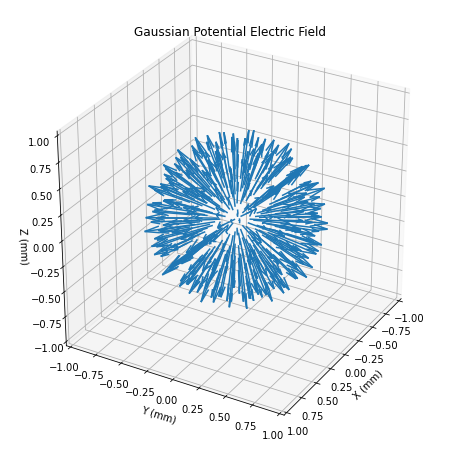

In [23]:
# Create a Cartesian grid
L = 1 * u.mm
grid = CartesianGrid(-L, L, num=100)

# Create a spherical potential with a Gaussian radial distribution
radius = np.linalg.norm(grid.grid, axis=3)
arg = (radius / (L / 3)).to(u.dimensionless_unscaled)
potential = 2e5 * np.exp(-(arg ** 2)) * u.V

# Calculate E from the potential
Ex, Ey, Ez = np.gradient(potential, grid.dax0, grid.dax1, grid.dax2)
Ex = -np.where(radius < L / 2, Ex, 0)
Ey = -np.where(radius < L / 2, Ey, 0)
Ez = -np.where(radius < L / 2, Ez, 0)

# Add those quantities to the grid
grid.add_quantities(E_x=Ex, E_y=Ey, E_z=Ez, phi=potential)


# Plot the E-field
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 30)

# skip some points to make the vector plot intelligable
s = tuple([slice(None, None, 6)] * 3)

ax.quiver(
    grid.pts0[s].to(u.mm).value,
    grid.pts1[s].to(u.mm).value,
    grid.pts2[s].to(u.mm).value,
    grid["E_x"][s],
    grid["E_y"][s],
    grid["E_z"][s],
    length=1e-6,
)

ax.set_xlabel("X (mm)")
ax.set_ylabel("Y (mm)")
ax.set_zlabel("Z (mm)")
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_zlim(-1, 1)
ax.set_title("Gaussian Potential Electric Field")

Prior to running the particle tracing algorithm, the simulation instance must be instantiated by providing some information about the setup, including the locations of the source and detector relative to the origin of the grid.

<img src="setup_graphic.png">

The source and detector coordinates are entered as a 3-tuple in one of three coordinate systems: Cartesian ($x$, $y$, $z$), spherical ($r$, $\theta$, $\phi$) or cylindrical ($r$, $\theta$, $z$). All values should be `astropy.units.Quantity` instances with units of either length or angle. The vector from the source to the detector should pass through the origin to maximize the number of particles that pass through the simulated fields.

In [18]:
source = (0 * u.mm, -10 * u.mm, 0 * u.mm)
detector = (0 * u.mm, 100 * u.mm, 0 * u.mm)

sim = prad.SyntheticProtonRadiograph(grid, source, detector, verbose=True)

Source: [ 0.   -0.01  0.  ] m
Detector: [0.  0.1 0. ] m
Magnification: 11.0


c:\users\peter\documents\github\plasmapy\plasmapy\diagnostics\proton_radiography.py:219: RuntimeWarning: B_x not specified for provided grid.This quantity will be assumed to be zero.
  RuntimeWarning,
c:\users\peter\documents\github\plasmapy\plasmapy\diagnostics\proton_radiography.py:219: RuntimeWarning: B_y not specified for provided grid.This quantity will be assumed to be zero.
  RuntimeWarning,
c:\users\peter\documents\github\plasmapy\plasmapy\diagnostics\proton_radiography.py:219: RuntimeWarning: B_z not specified for provided grid.This quantity will be assumed to be zero.
  RuntimeWarning,


Note that, since the example grid did not include a B-field, the B-field is assumed to be zero and a warning is printed.

Next, a distribution of `nparticles` simulated particles of energy `proton_energy` is created. Setting the `max_theta` parameter eliminates particles with large angles (relative to the source-detector axis) which otherwise would likely not hit the detector. Particles with angles less than $\theta_{max}$ but greater than $\theta_{track}$ in the setup figure above will not cross the grid. These particles are retained, but are coasted directly to the detector plane instead of being pushed through the grid.

By default, the particle velocities are initialized with random angles (a Monte-Carlo approach) with a uniform flux per unit solid angle. However, particles can also be initialized in other ways by setting the `distribution` keyword.

In [19]:
sim.create_particles(1e5, 3 * u.MeV, max_theta=np.pi / 15 * u.rad)

Creating Particles


The simulation is now ready to run. In brief, the steps of the simulation cycle are as follows:

1. Particles that will never hit the field grid are ignored (until a later step, when they will be automatically advanced to the detector plane).


2. Particles are advanced to the time when the first particle enters the simulation volume. This is done in one step to save computation time.


3. While particles are on the grid, the particle pusher advances them each timestep by executing the following steps:

    A. The fields at each particle's location are interpolated using the interpolators defined in the `plasmapy.plasma.grids.AbstractGrid` subclasses.
    
    B. The simulation timestep is automatically (and adaptively) calculated based on the proton energy, grid resolution, and field amplitudes. This timestep can be clamped or overridden by setting the `dt` keyword in the `run()` function.
    
    C. An implementation of the Boris particle push algorithm is used to advance the velocities and positions of the particles in the interpolated fields.
    
    
4. After all of the particles have left the grid, all particles are advanced to the detector plane (again saving time). Particles that are headed away from the detector plane at this point are deleted, as those particles will never
be detected.

When the simulation runs, a progress meter will show the number of particles currently on the grid. This bar will start at zero, increase as particles enter the grid, then decrease as they leave it. When almost all particles have left the grid, the simulation ends.

In [25]:
sim.run()

Particles on grid:   0%|          1.6e+02/5.6e+04 particles
Run completed
Fraction of particles tracked: 55.5%
Fraction of tracked particles that entered the grid: 64.0%
Fraction of tracked particles deflected away from the detector plane: 0.0%


The following plot illustrates that, after the simulation has ended, all particles have been advanced to the detector plane.

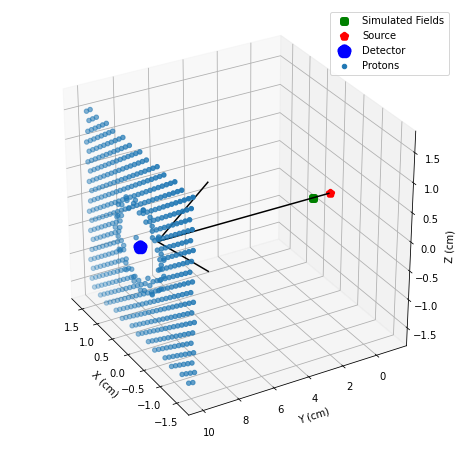

In [32]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 150)
ax.set_xlabel("X (cm)")
ax.set_ylabel("Y (cm)")
ax.set_zlabel("Z (cm)")

# Plot the source-to-detector axis
ax.quiver(
    sim.source[0] * 100,
    sim.source[1] * 100,
    sim.source[2] * 100,
    sim.detector[0] * 100,
    sim.detector[1] * 100,
    sim.detector[2] * 100,
    color="black",
)

# Plot the simulation field grid volume
ax.scatter(0, 0, 0, color="green", marker="s", linewidth=5, label="Simulated Fields")

# Plot the the proton source and detector plane locations
ax.scatter(
    sim.source[0] * 100,
    sim.source[1] * 100,
    sim.source[2] * 100,
    color="red",
    marker="*",
    linewidth=5,
    label="Source",
)

ax.scatter(
    sim.detector[0] * 100,
    sim.detector[1] * 100,
    sim.detector[2] * 100,
    color="blue",
    marker="*",
    linewidth=10,
    label="Detector",
)


# Plot the final proton positions of some (not all) of the protons
ind = slice(None, None, 200)
ax.scatter(
    sim.x[ind, 0] * 100, sim.x[ind, 1] * 100, sim.x[ind, 2] * 100, label="Protons",
)

ax.legend()

A 'synthetic proton radiograph' can now be constructed by creating a 2D histogram of proton positions in the image plane. The synthetic radiograph function takes two keywords:

- 'size' gives the locations of the lower left and upper right corners of the detector grid in image plane coordinates.

- 'bins' is the number of histogram bins to be used in the horizontal and vertical directions. Using more bins creates a higher resolution image, but at the cost of more noise.

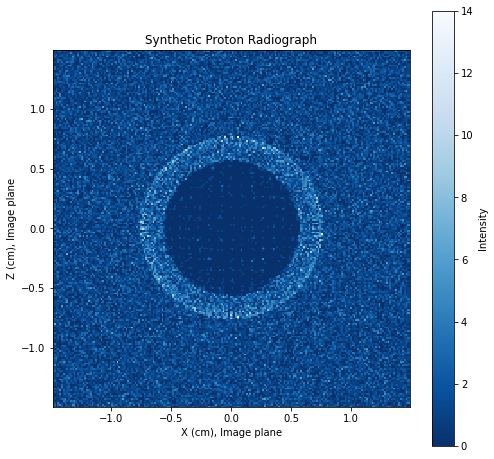

In [28]:
# A function to reduce repetative plotting
def plot_radiograph(hax, vax, intensity):
    fig, ax = plt.subplots(figsize=(8, 8))
    plot = ax.pcolormesh(
        hax.to(u.cm).value, vax.to(u.cm).value, intensity.T, cmap="Blues_r",
    )
    cb = fig.colorbar(plot)
    cb.ax.set_ylabel("Intensity")
    ax.set_aspect("equal")
    ax.set_xlabel("X (cm), Image plane")
    ax.set_ylabel("Z (cm), Image plane")
    ax.set_title("Synthetic Proton Radiograph")


size = np.array([[-1, 1], [-1, 1]]) * 1.5 * u.cm
bins = [200, 200]
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins)
plot_radiograph(hax, vax, intensity)

As expected, the outward-pointing electric field in the sphere has deflected the protons out of the central region, leaving a dark shadow.

Kugland et al. 2012 and Bott et al. 2017 define the dimensionless "contrast parameter" that separates different regimes of proton radiography:

\begin{equation}
\mu = \frac{l \alpha}{a}
\end{equation}
Where $l$ is the distance from the source to the grid, $a$ is the spatial scale of the scattering electromagnetic fields, and $\alpha$ is the particle deflection angle. The value of $\mu$ can fall in one of three regimes:

\begin{align}
\mu &\ll 1 \rightarrow \text{ linear}\\
\mu &< \mu_c \rightarrow \text{ nonlinear injective}\\
\mu &> \mu_c \rightarrow \text{ caustic}\\
\end{align}

where $\mu_c \sim 1$ is a characteristic value at which particle paths cross, leading to the formation of bright caustics. Correctly placing a radiograph in the correct regime is necessary to determine which analysis techniques can be applied to it.

The maximum deflection angle can be calculated after the simulation has run by comparing the initial and final velocity vectors of each particle

In [29]:
max_deflection = sim.max_deflection
print(f"Maximum deflection α = {np.rad2deg(max_deflection):.2f} deg")

Maximum deflection α = 2.77 deg


The spatial scale of the field constructed in this example is $\sim$ 1 mm, and $l$ is approximately the distance from the source to the grid origin. Therefore, we can calculate the value of $\mu$

In [30]:
a = 1 * u.mm
l = np.linalg.norm(sim.source * u.m).to(u.mm)
mu = l * max_deflection / a
print(f"a = {a}")
print(f"l = {l:.1f}")
print(f"μ = {mu:.2f}")

a = 1.0 mm
l = 10.0 mm
μ = 0.48


which places this radiograph in the non-linear injective regime.

## Options

For sake of comparison, here is the result achieved by setting `distribution = 'uniform'` in the `create_particles()` function.

Creating Particles
Particles on grid:   0%|          2.2e+02/8.6e+04 particles
Run completed
Fraction of particles tracked: 85.9%
Fraction of tracked particles that entered the grid: 66.0%
Fraction of tracked particles deflected away from the detector plane: 0.0%


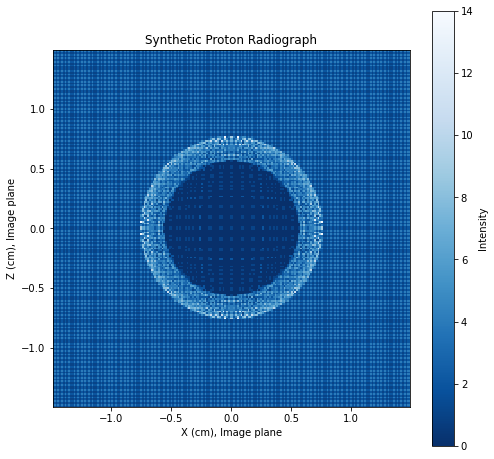

In [31]:
sim.create_particles(
    1e5, 3 * u.MeV, max_theta=np.pi / 15 * u.rad, distribution="uniform"
)
sim.run()
size = np.array([[-1, 1], [-1, 1]]) * 1.5 * u.cm
bins = [200, 200]
hax, vax, intensity = sim.synthetic_radiograph(size=size, bins=bins)
plot_radiograph(hax, vax, intensity)